In [17]:
from PIL import Image
import os
import torch
from torchvision import transforms
import numpy as np
import torch.utils.data as data_utils
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision.transforms.functional as TF
from tqdm import tqdm
from colorama import Fore
import sys
from itertools import groupby
from torchsummary import summary
import matplotlib as mpl
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [2]:
digits_per_sequence = 10 
gpu = torch.device('cuda')

dataset_sequences = []
dataset_labels = [] 
transformed_random_digits_images = []

In [3]:
src_root = './dataset'
save_root = './dataset_sequence'

text = open('groundTruthValues.txt')
lines = text.readlines()
# i = 0

for linenumber, line in enumerate(lines[1:]):
    img_name = line.split(',')[0]
    # print(seq_name)
    str_gt = line.split(',')[1].split('\n')[0]
    # print(str_gt)
    img = Image.open(os.path.join(src_root, img_name + '.png'))
    linenumber = linenumber % 16 #16 because number of lines per image to read
    bbox = (0, 32*linenumber, 320, 32*(linenumber+1))
    seq = img.crop(bbox)
    seq = transforms.Grayscale(num_output_channels=1)(seq)
    # print(seq.size)
    # seq.save(os.path.join(save_root, str(img_name) + '_' + str(linenumber) + '_' + '.png'))
    # print('index: ', i, 'line_number: ', linenumber)
    # i = i + 1
    imgs_seq_lst = []
    labels_seq_lst = []
    transformed_random_digits_images = []

    for column_number,gt in enumerate(str_gt):
        bbox = (32*column_number, 0, 32*(column_number+1), 32)
        seq_c = seq.crop(bbox)
#         seq_c = np.array(transforms.Resize((28,28),interpolation=Image.NEAREST)(seq_c))
        seq_c = np.array(seq_c)

        if (gt == 'X'):
            gt = '10'
            
        labels_seq_lst.append(gt)
        imgs_seq_lst.append(seq_c)    

#     imgs_seq = torch.tensor(np.array(imgs_seq_lst)).unsqueeze(1)
    imgs_seq = torch.tensor(np.array(imgs_seq_lst))
#     print(imgs_seq.shape) # torch.Size([10, 32, 32])
    # imgs_seq_arr = np.expand_dims(imgs_seq_arr, axis=1)

    # labels_seq_arr = np.array(labels_seq_lst).astype(int)
    labels_seq = torch.tensor(np.array(labels_seq_lst).astype(int))

    for img in imgs_seq:
#         print(img.shape)
        img = transforms.ToPILImage()(img)
        # transformation...
        # img = TF.rotate(img, -90, fill=0)
        # img = TF.hflip(img)
        # img = transforms.RandomAffine(degrees=10, translate=(0.2, 0.15), scale=(0.8, 1.1))(img)
        
        img = transforms.ToTensor()(img).numpy()
        transformed_random_digits_images.append(img)

    random_digits_images = np.array(transformed_random_digits_images)
    random_sequence = np.hstack(random_digits_images.reshape((digits_per_sequence, 32, 32)))
    random_labels = np.hstack(labels_seq.reshape(digits_per_sequence, 1))
#     print(random_sequence.shape) (32, 320)
#     print(random_labels.shape) (10,)
    dataset_sequences.append(random_sequence / 255)
    dataset_labels.append(random_labels)    

In [5]:
dataset_data = torch.Tensor(np.array(dataset_sequences))
dataset_labels = torch.IntTensor(np.array(dataset_labels))

seq_dataset = data_utils.TensorDataset(dataset_data, dataset_labels)
train_set, val_set = torch.utils.data.random_split(seq_dataset,
                                                   [int(np.round(len(seq_dataset) * 0.8)), int(np.round(len(seq_dataset) * 0.2))])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=True)

In [6]:
epochs = 20
cnn_output_height = 5
cnn_output_width = 77
gru_num_layers = 2
gru_hidden_size = 64
num_classes = 12
blank_label = 11

In [30]:
class CRNN(nn.Module):

    def __init__(self):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3))
        self.norm1 = nn.InstanceNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), stride=2)
        self.norm2 = nn.InstanceNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.norm3 = nn.InstanceNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=2)
        self.norm4 = nn.InstanceNorm2d(64)
#         self.gru_input_size = cnn_output_height * 64
        self.lstm_input_size = cnn_output_height * 64
        self.lstm_hidden_size = 64
        self.lstm_num_layers = 2
#         self.lstm_hidden = Variable(torch.zeros(self.lstm_num_layers * 2, batch_size, self.lstm_hidden_size))
#         self.lstm_cell = Variable(torch.zeros(self.lstm_num_layers * 2, batch_size, self.lstm_hidden_size))
#         self.gru = nn.GRU(self.gru_input_size, gru_hidden_size, gru_num_layers, batch_first=True, bidirectional=True)
        self.lstm = nn.LSTM(self.lstm_input_size, self.lstm_hidden_size, self.lstm_num_layers, batch_first = True, bidirectional = True)
        self.fc = nn.Linear(gru_hidden_size * 2, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]
        out = self.conv1(x)
        out = self.norm1(out)
        out = F.leaky_relu(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out = F.leaky_relu(out)
        out = self.conv3(out)
        out = self.norm3(out)
        out = F.leaky_relu(out)
        out = self.conv4(out)
        out = self.norm4(out)
        out = F.leaky_relu(out)
        out = out.permute(0, 3, 2, 1)
        out = out.reshape(batch_size, -1, self.lstm_input_size)
        self.lstm_hidden = Variable(torch.zeros(self.lstm_num_layers * 2, batch_size, self.lstm_hidden_size).cuda())
        self.lstm_cell = Variable(torch.zeros(self.lstm_num_layers * 2, batch_size, self.lstm_hidden_size).cuda())
#         out, _ = self.gru(out)
        out, self.lstm_hidden = self.lstm(out, (self.lstm_hidden, self.lstm_cell))
        out = torch.stack([F.log_softmax(self.fc(out[i]), dim=-1) for i in range(out.shape[0])])
        return out

In [31]:
# model = LeNetGRU().to(gpu)
# model = LeNet(11).to(gpu)
model = CRNN().to(gpu)
# criterion = nn.CTCLoss(reduction='mean', zero_infinity=True)
criterion = nn.CTCLoss(blank=blank_label, reduction='mean', zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [29]:
# summary(model, (1, 32, 320))

#  Training

In [9]:
# best_valid_loss = float('inf')
# for _ in range(epochs):
#     # ============================================ TRAINING ============================================================
#     train_correct = 0
#     train_total = 0
#     for x_train, y_train in tqdm(train_loader,
#                                  position=0, leave=True,
#                                  file=sys.stdout, bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.GREEN, Fore.RESET)):
#         batch_size = x_train.shape[0]  # x_train.shape == torch.Size([64, 28, 140])
#         x_train = x_train.view(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
#         optimizer.zero_grad()
#         y_pred = model(x_train.cuda())
#         y_pred = y_pred.permute(1, 0, 2)  # y_pred.shape == torch.Size([64, 32, 11])
#         input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
#         target_lengths = torch.IntTensor([len(t) for t in y_train])
#         loss = criterion(y_pred, y_train, input_lengths, target_lengths)
#         loss.backward()
#         optimizer.step()
#         _, max_index = torch.max(y_pred, dim=2)  # max_index.shape == torch.Size([32, 64])
#         for i in range(batch_size):
#             raw_prediction = list(max_index[:, i].detach().cpu().numpy())  # len(raw_prediction) == 32
#             prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
# #             prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction)])
# #             print(len(prediction)) #varies
# #             print(len(y_train[i]))
#             if len(prediction) == len(y_train[i]) and torch.all(prediction.eq(y_train[i])):
#                 train_correct += 1
#             train_total += 1
#     print('TRAINING. Correct: ', train_correct, '/', train_total, '=', train_correct / train_total)

#     # ============================================ VALIDATION ==========================================================
#     val_correct = 0
#     val_total = 0
#     for x_val, y_val in tqdm(val_loader,
#                              position=0, leave=True,
#                              file=sys.stdout, bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.BLUE, Fore.RESET)):
#         batch_size = x_val.shape[0]
#         x_val = x_val.view(x_val.shape[0], 1, x_val.shape[1], x_val.shape[2])
#         y_pred = model(x_val.cuda())
#         y_pred = y_pred.permute(1, 0, 2)
#         input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
#         target_lengths = torch.IntTensor([len(t) for t in y_val])
#         valid_loss = criterion(y_pred, y_val, input_lengths, target_lengths)
#         if valid_loss < best_valid_loss:
#             best_valid_loss = valid_loss
#             torch.save(model.state_dict(), 'multidig-model.pt')
#             print('Model updated')
#         _, max_index = torch.max(y_pred, dim=2)
#         for i in range(batch_size):
#             raw_prediction = list(max_index[:, i].detach().cpu().numpy())
#             prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
# #             prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction)])
#             if len(prediction) == len(y_val[i]) and torch.all(prediction.eq(y_val[i])):
#                 val_correct += 1
#             val_total += 1
#     print('TESTING. Correct: ', val_correct, '/', val_total, '=', val_correct / val_total)

100%|██████████| 198/198 [03:16<00:00,  1.01it/s]
TRAINING. Correct:  0 / 12659 = 0.0
100%|██████████| 3165/3165 [02:52<00:00, 18.37it/s]
TESTING. Correct:  0 / 3165 = 0.0
100%|██████████| 198/198 [03:23<00:00,  1.03s/it]
TRAINING. Correct:  0 / 12659 = 0.0
100%|██████████| 3165/3165 [02:55<00:00, 18.03it/s]
TESTING. Correct:  0 / 3165 = 0.0
100%|██████████| 198/198 [03:16<00:00,  1.01it/s]
TRAINING. Correct:  6863 / 12659 = 0.5421439292203175
  0%|          | 0/3165 [00:00<?, ?it/s]Model updated
Model updated
  0%|          | 2/3165 [00:00<03:55, 13.42it/s]Model updated
Model updated
100%|██████████| 3165/3165 [03:01<00:00, 17.44it/s]
TESTING. Correct:  2463 / 3165 = 0.7781990521327015
100%|██████████| 198/198 [03:13<00:00,  1.02it/s]
TRAINING. Correct:  10567 / 12659 = 0.8347420807330753
100%|██████████| 3165/3165 [03:04<00:00, 17.14it/s]
TESTING. Correct:  2733 / 3165 = 0.8635071090047394
100%|██████████| 198/198 [03:25<00:00,  1.04s/it]
TRAINING. Correct:  11363 / 12659 = 0.8976222

In [32]:
best_valid_loss = float('inf')
for _ in range(epochs):
    # ============================================ TRAINING ============================================================
    train_correct = 0
    train_total = 0
    for x_train, y_train in tqdm(train_loader,
                                 position=0, leave=True,
                                 file=sys.stdout, bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.GREEN, Fore.RESET)):
        batch_size = x_train.shape[0]  # x_train.shape == torch.Size([64, 28, 140])
        x_train = x_train.view(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
        optimizer.zero_grad()
        y_pred = model(x_train.cuda())
        y_pred = y_pred.permute(1, 0, 2)  # y_pred.shape == torch.Size([64, 32, 11])
        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
        target_lengths = torch.IntTensor([len(t) for t in y_train])
        loss = criterion(y_pred, y_train, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        _, max_index = torch.max(y_pred, dim=2)  # max_index.shape == torch.Size([32, 64])
        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())  # len(raw_prediction) == 32
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
#             prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction)])
#             print(len(prediction)) #varies
#             print(len(y_train[i]))
            if len(prediction) == len(y_train[i]) and torch.all(prediction.eq(y_train[i])):
                train_correct += 1
            train_total += 1
    print('TRAINING. Correct: ', train_correct, '/', train_total, '=', train_correct / train_total)

    # ============================================ VALIDATION ==========================================================
    val_correct = 0
    val_total = 0
    for x_val, y_val in tqdm(val_loader,
                             position=0, leave=True,
                             file=sys.stdout, bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.BLUE, Fore.RESET)):
        batch_size = x_val.shape[0]
        x_val = x_val.view(x_val.shape[0], 1, x_val.shape[1], x_val.shape[2])
        y_pred = model(x_val.cuda())
        y_pred = y_pred.permute(1, 0, 2)
        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
        target_lengths = torch.IntTensor([len(t) for t in y_val])
        valid_loss = criterion(y_pred, y_val, input_lengths, target_lengths)
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'multidig-model.pt')
            print('Model updated')
        _, max_index = torch.max(y_pred, dim=2)
        for i in range(batch_size):
            raw_prediction = list(max_index[:, i].detach().cpu().numpy())
            prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
#             prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction)])
            if len(prediction) == len(y_val[i]) and torch.all(prediction.eq(y_val[i])):
                val_correct += 1
            val_total += 1
    print('TESTING. Correct: ', val_correct, '/', val_total, '=', val_correct / val_total)

 24%|██▎       | 47/198 [01:02<03:21,  1.33s/it]


KeyboardInterrupt: 

# Testing

In [21]:
model.load_state_dict(torch.load('multidig-model.pt'))

<All keys matched successfully>

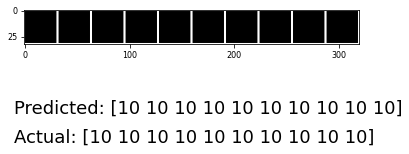

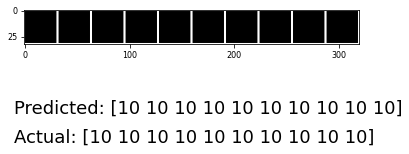

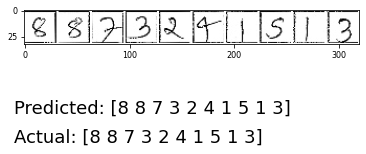

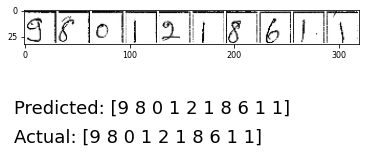

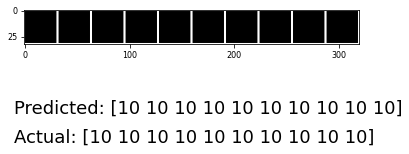

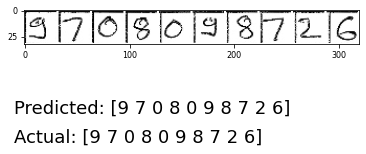

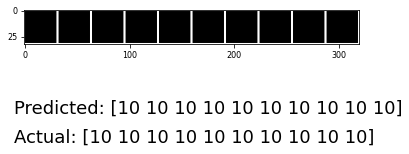

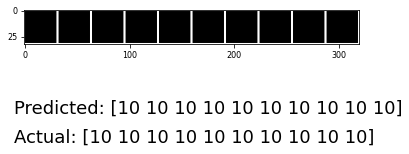

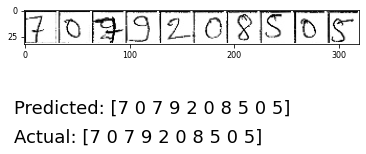

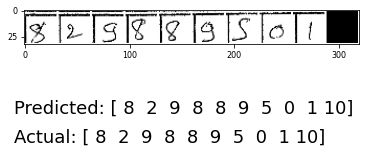

In [26]:
number_of_test_imgs = 10
test_loader = torch.utils.data.DataLoader(val_set, batch_size=number_of_test_imgs, shuffle=True)
test_preds = []
(x_test, y_test) = next(iter(test_loader))
y_pred = model(x_test.view(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2]).cuda())
y_pred = y_pred.permute(1, 0, 2)
_, max_index = torch.max(y_pred, dim=2)
for i in range(x_test.shape[0]):
    raw_prediction = list(max_index[:, i].detach().cpu().numpy())
    prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != blank_label])
    test_preds.append(prediction)

for j in range(len(x_test)):
    mpl.rcParams["font.size"] = 8
    plt.imshow(x_test[j], cmap='gray')
    mpl.rcParams["font.size"] = 18
    plt.gcf().text(x=0.1, y=0.1, s="Actual: " + str(y_test[j].numpy()))
    plt.gcf().text(x=0.1, y=0.2, s="Predicted: " + str(test_preds[j].numpy()))
    plt.show()